In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A

# In[2]:


import torch
torch.cuda.set_device(1)

In [7]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_train.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)
                

In [8]:
create_csvValid("./dataset_split_38frames/train")

In [4]:
import pandas as pd
import numpy as np

dfValid = pd.read_csv('./dataset_split_38frames/df_train.csv')

dfTest = pd.read_csv('./dataset_split_38frames/df_test.csv')


# In[5]:


# prueba = dfValid


# prueba = prueba.iloc[np.random.permutation(len(prueba))]
# prueba = prueba[0:int(len(prueba)*0.1)]
# # In[6]:
# # Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# # usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# # dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]




# # Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# # 0.1 posiciones si está se devuelve 
# def is_valid(path):
#     name = path[0]
# #     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
#     return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# # In[13]:

# def get_class(path):
#     name = path[0]
#     return (dfValid[dfValid['images']==name])['class']


In [5]:
def get_dls(presize=50,size=38,M=0,bs=512):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=RandomSplitter(),
             get_x = ColReader(0,pref="./dataset_split_38frames/train/",suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfValid.values,bs=bs)
    return dls

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrsRandAugLS',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [7]:
dlsTrain3 = get_dls()


learn = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks,
                loss_func= LabelSmoothingCrossEntropyFlat()).to_fp16()

SuggestedLRs(valley=0.0002754228771664202)

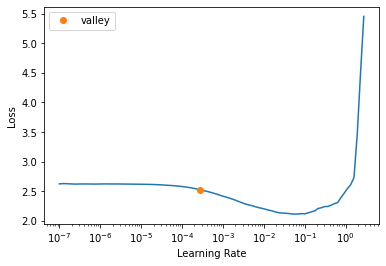

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.375747,1.456669,0.630999,0.784773,00:14


Better model found at epoch 0 with cohen_kappa_score value: 0.7847734498140695.


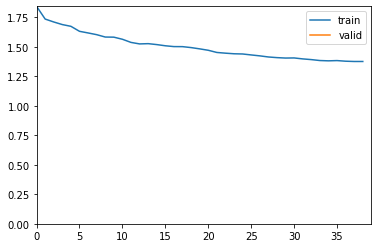

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.101967,1.043725,0.772620,0.886024,00:06
1,1.019343,1.001188,0.789929,0.897347,00:06
2,0.964212,0.982574,0.807238,0.926830,00:06
3,0.919614,0.952179,0.822187,0.931729,00:06
4,0.868904,0.926891,0.834776,0.934419,00:06
5,0.829959,0.929632,0.833989,0.929088,00:06
6,0.793100,0.936426,0.828481,0.927811,00:06
7,0.766273,0.930999,0.834776,0.938563,00:06
8,0.743471,0.919363,0.840283,0.935119,00:06
9,0.720645,0.931869,0.851298,0.925144,00:06


Better model found at epoch 0 with cohen_kappa_score value: 0.8860235380131825.


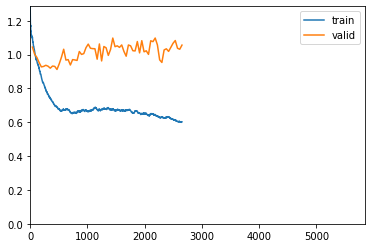

Better model found at epoch 1 with cohen_kappa_score value: 0.8973472102421348.
Better model found at epoch 2 with cohen_kappa_score value: 0.9268304149629727.
Better model found at epoch 3 with cohen_kappa_score value: 0.931728678992551.
Better model found at epoch 4 with cohen_kappa_score value: 0.9344186094099183.
Better model found at epoch 7 with cohen_kappa_score value: 0.9385625179901593.
Better model found at epoch 10 with cohen_kappa_score value: 0.9406863008884165.
Epoch 21: reducing lr to 8.779869054982784e-05
Epoch 31: reducing lr to 0.00012685499279306654
Epoch 41: reducing lr to 0.00014866642831294977
Epoch 51: reducing lr to 0.00014837302891009603
Better model found at epoch 58 with cohen_kappa_score value: 0.9426602959488254.
Epoch 61: reducing lr to 0.00014053371547155424


KeyboardInterrupt: 

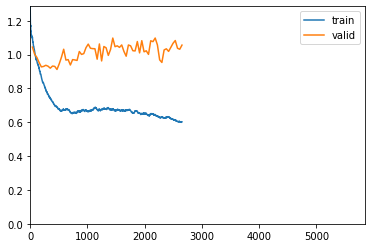

In [42]:
learn.fine_tune(150,base_lr=3e-3)

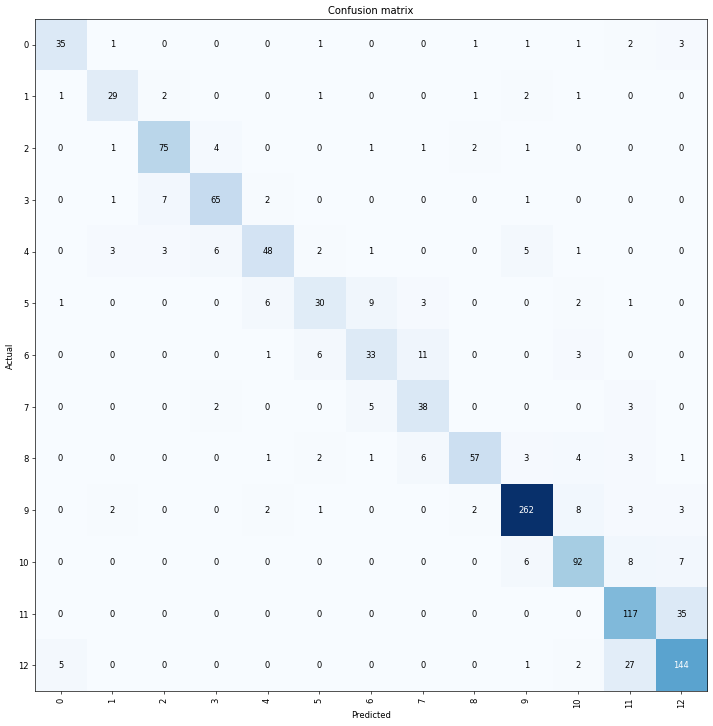

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [44]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = ColReader(0,pref="./dataset_split_38frames/test/",suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(100),
                 batch_tfms=[*aug_transforms(size=38, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTest.values,bs=128)



# dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),get_items=get_image_files, 
#                    splitter=GrandparentSplitter(valid_name='test'),get_y=parent_label, 
#                    item_tfms = Resize(512),batch_tfms=[*aug_transforms(size=256, min_scale=0.75), 
#                    Normalize.from_stats(*imagenet_stats)])
# dlsTest = dbTest.dataloaders("./dataset_split_77frames/df_test.csv",bs=32)

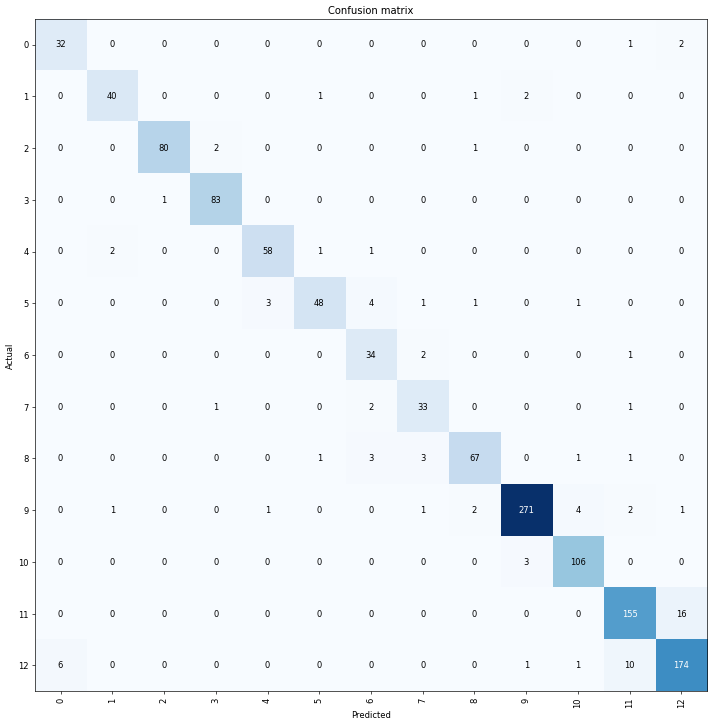

In [45]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [46]:
# learn.validate()

In [47]:
# learn.export(fname='resnetrsRandAugLS_77frames.pkl')

In [48]:
learn1 = Learner(dlsTest,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')]).to_fp16()

In [49]:
# learn1.load("resnetrsRandAugLS")
learn1.load("resnetrsRandAugLS")

In [51]:
learn1.export("resnetrsRandAugLS_38frames.pkl")

In [52]:
learn1.validate()

(#3) [0.23372822999954224,0.9567269682884216,0.9813530963949226]

In [17]:
preds,gt = learn1.tta()

In [18]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
accuracy_score(np.argmax(preds,axis=1),gt)

0.07631785995279308

In [29]:
learn1 = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')]).to_fp16()

In [58]:
path_vid = './dataset_split_38frames/test/IDU027V002_20220209_163603'
imgs = []
probs = []
for _, line in dfTest.iterrows():
#     print(line[0])
    if "IDU002V001" in line[0]:
        imgs.append(line[0])
# print(imgs)

for img in imgs:
    img = img + '.jpg'
    _,_,probs1 = learn1.predict('./dataset_split_38frames/test/'+img)
    probs.append(probs1)

    

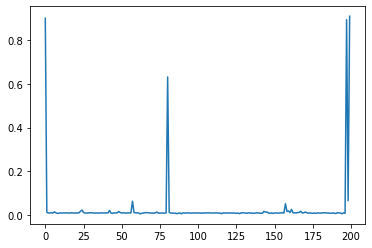

In [59]:
from matplotlib.pyplot import plot
plot(range(0,len(probs)),[x[0] for x in probs])

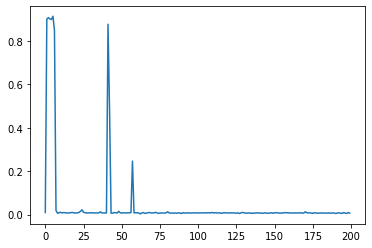

In [60]:
plot(range(0,len(probs)),[x[1] for x in probs])

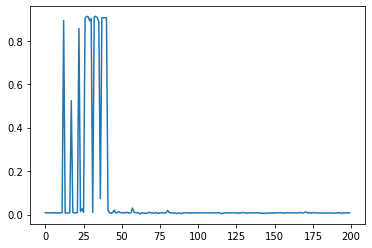

In [61]:
plot(range(0,len(probs)),[x[3] for x in probs])

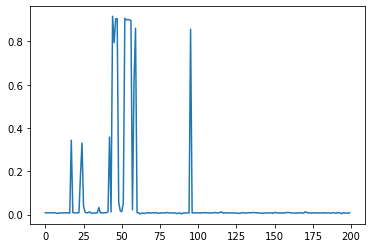

In [62]:
plot(range(0,len(probs)),[x[4] for x in probs])

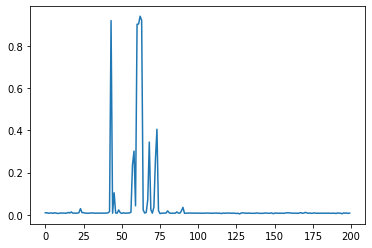

In [63]:
plot(range(0,len(probs)),[x[5] for x in probs])

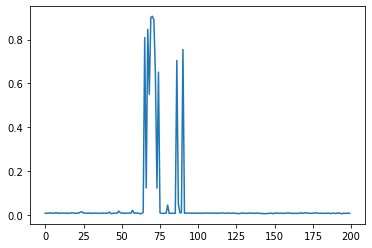

In [64]:
plot(range(0,len(probs)),[x[6] for x in probs])

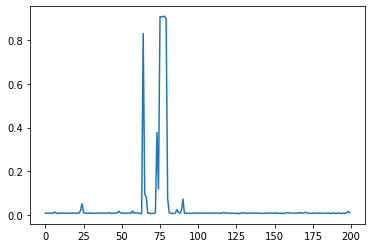

In [65]:
plot(range(0,len(probs)),[x[7] for x in probs])

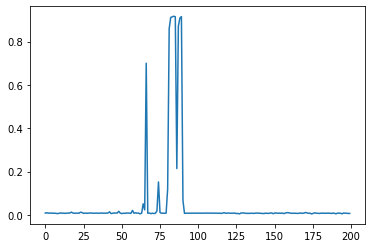

In [66]:
plot(range(0,len(probs)),[x[8] for x in probs])

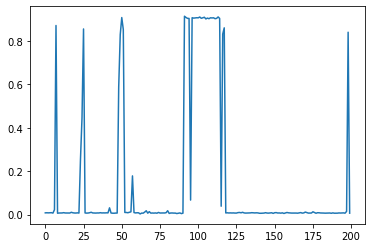

In [67]:
plot(range(0,len(probs)),[x[9] for x in probs])

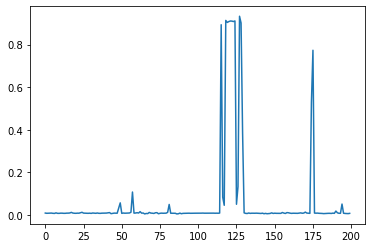

In [68]:
plot(range(0,len(probs)),[x[10] for x in probs])

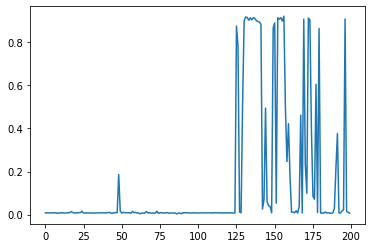

In [69]:
plot(range(0,len(probs)),[x[11] for x in probs])

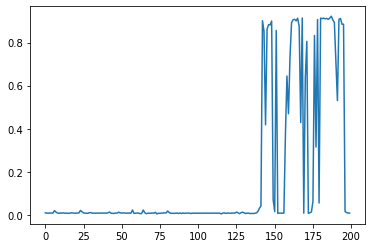

In [70]:
plot(range(0,len(probs)),[x[12] for x in probs])